# Assignment 6
Alexander Ly 
027744520
CECS 456 Sec 02
Arjang Fahim

In [28]:
# imports
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os

In [29]:
# load the training images from the kaggle dataset
train_images = 'C:\\Users\\Alex\\Desktop\\train'

In [30]:
# create parameters 
batch_size = 32
img_height = 64
img_width = 64

# training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_images,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_images,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [31]:
# names of different classes from our images
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


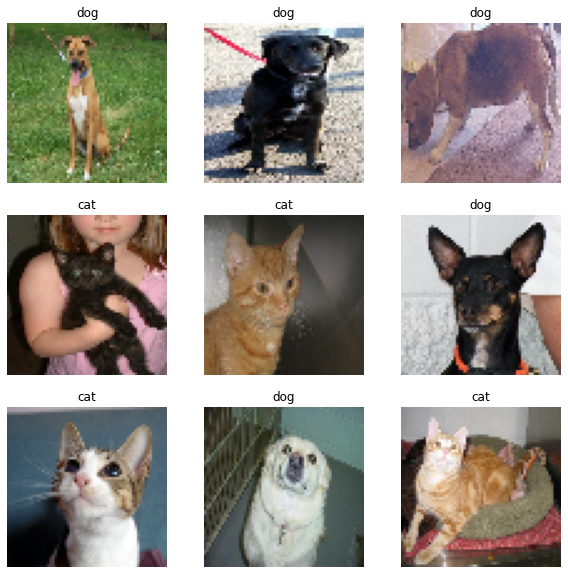

In [48]:
# plotting some of the images from the training set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [33]:
# buffered prefetching when loading data
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
# standarizing the data to be in range of [0,1]
normalization_layer = layers.Rescaling(1./255)

In [35]:
# apply layer
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.9993933


In [36]:
# create model 
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [37]:
# implement data augmentation for overfitting
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

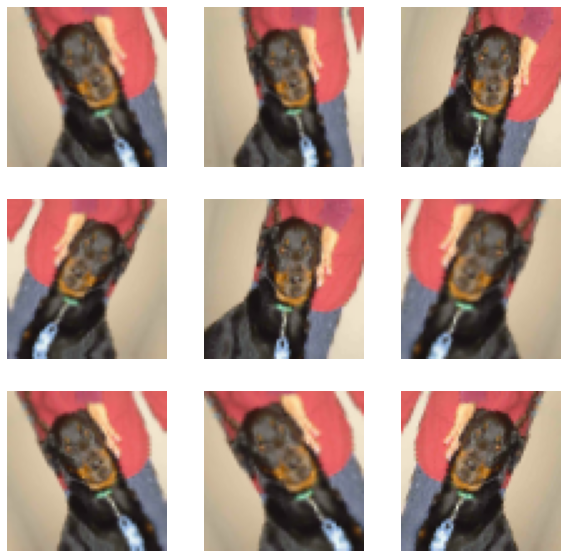

In [38]:
# plot the data augmentation to view how it was implemented
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [39]:
# introduce dropout to model
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [40]:
# compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
# display summary of NNA
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 rescaling_6 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                 

In [45]:
# train model
epochs=25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
625/625 [==============================] - 25s 40ms/step - loss: 0.3632 - accuracy: 0.8348 - val_loss: 0.3594 - val_accuracy: 0.8364
Epoch 2/25
625/625 [==============================] - 24s 39ms/step - loss: 0.3529 - accuracy: 0.8433 - val_loss: 0.3517 - val_accuracy: 0.8412
Epoch 3/25
625/625 [==============================] - 24s 39ms/step - loss: 0.3495 - accuracy: 0.8450 - val_loss: 0.3452 - val_accuracy: 0.8496
Epoch 4/25
625/625 [==============================] - 24s 38ms/step - loss: 0.3475 - accuracy: 0.8461 - val_loss: 0.3362 - val_accuracy: 0.8478
Epoch 5/25
625/625 [==============================] - 23s 38ms/step - loss: 0.3399 - accuracy: 0.8497 - val_loss: 0.3612 - val_accuracy: 0.8410
Epoch 6/25
625/625 [==============================] - 23s 37ms/step - loss: 0.3378 - accuracy: 0.8512 - val_loss: 0.3298 - val_accuracy: 0.8566
Epoch 7/25
625/625 [==============================] - 24s 38ms/step - loss: 0.3376 - accuracy: 0.8508 - val_loss: 0.3856 - val_accuracy:

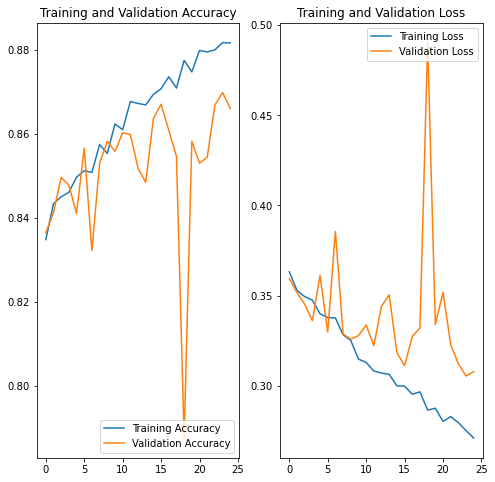

In [46]:
# visualize trained results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
# test our trained model with different images from our test data file
image_path = 'C:\\Users\\Alex\\Desktop\\test_data\\dog\\dog10.jpeg'

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to dog with a 97.36 percent confidence.


1. There were many different parameters and values which could have been changed to find my best training accuracy. From what I tested and found out, it looked like having an epoch of 25 seemed to be the best since when testing lower epochs, I got a lower accuracy (most likely because underfitting), and I also didn't want to go above 25 since overfitting could have occured. In addition, for the batch size, when testing a batch size of 64, the accuracy dropped about .025% and same went for when testing with a batch size of 16. I found the batch size of 32 to be the best for accuracy. When testing my data with better dimensions for the image height and width (32x32 to 64x64), it took longer for the epochs to finish the training but the training accuracy increased greatly. It went from nearly an 80% accuracy to about nearly an 85% accuracy(testing with epoch of 15). I wasn't able to test out the 128x128 image width and height since when trying, it took my computer quite a while but from my guess, the training accuracy would have also increased since the resolution on the image would have been more clear for the training to identify key features of the cats and dogs. 

2. The best training and validation accuracy results was about ~88% training accuracy and ~86% validation accuracy. When testing with different parameters and values, there were times when I did get higher validation accuracy however the training accuracy was lowered. For the loss plot, it seemed like having more epochs constantly improved the training loss values and the validation loss values. This just meant that with more epochs the model was constantly getting better at learning the model and getting better at making predictions based off the images from the model. When testing with an epoch of 15, the loss value was ~0.3 and the val_loss or validation loss value was ~0.32 however, when changing to an epoch of 25, the loss value was ~0.27 and the val_loss was ~0.3 meaning the model was adapting.  

3. Excel file

4. The accuracy of my testing was 15/20 which is 75% (tested with batch size 32, image height and width 32x32, epoch=15). Although this lower than both the training and validation accuracies, it still comes close to it with approximately a 5% difference which isn't too bad but is noticable. This could be because my model might be slightly overfitting to the training data and since it learnt the data too well, it's not good at generalizing data which it hasn't seen. Even with adding the data augmentation, there still seemed to be overfitting occuring which would mean that I would most likely have to improve the data augmentation. From what I read and saw, I could have added more transformation layers than the three that I was using such as layers like: shifting, birghtness, noise, or shearing. In addition, I could have changed the parameters on the current layers to test and see if there could have been improvements there. 